# 1D Plug Flow Reactor Model with Surface Chemistry
In this model, we will illustrate the derivation of the governing differential equations and algebraic constraints, calculation of the initial conditions of the variables and their spatial derivatives and use the IDA solver to solve this system of differential algebraic equations (DAE).

Requires the [scikits.odes.dae](http://scikits-odes.readthedocs.io/en/latest/guide.html#object-oriented-interface-ode-and-dae) solver. The easiest way to install this package is from the `conda-forge` channel using `conda`.

In [2]:
import numpy as np
from scikits.odes import dae
import cantera as ct

%matplotlib inline
%config InlineBackend.figure_formats = ["svg"]
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 120

print(f"Runnning Cantera version: {ct.__version__}")

Runnning Cantera version: 2.6.0


In [3]:
# import the SiF4 + NH3 reaction mechanism
mech = 'methane_Bjarne.yaml'
# mech = 'methaneReformingNi.yaml'
# import the models for gas and bulk
gas = ct.Solution(mech, 'gas')
# import the model for gas-Si-N interface
gas_Si_N_interface = ct.Interface(mech,'surface1', [gas])
n_gas_reactions = 0

In [4]:
# T0 = 1273  # Kelvin
# p0 = 1e5
# gas.TPX = T0, p0, "O2:0.006, CH4:0.003, N2:0.991"  # inlet composition
# gas_Si_N_interface.TP = T0, p0
# gas_Si_N_interface.coverages = "Pt(9): 1.0"
# Yk_0 = gas.Y
# rho0 = gas.density
# u0 = 11.53  # m/s initial velocity of the flow
# D = 5.08e-2  # diameter of the tube [m]
# Ac = np.pi * D**2 / 4  # cross section of the tube [m^2]
# mu = 5.7e-5  # kg/(m-s) dynamic viscosity
# perim = np.pi * D  # perimeter of the tube

T0 = 1273  # Kelvin
p0 = 1e5
gas.TPX = T0, p0, "O2:0.006, CH4:0.003, N2:0.991"  # inlet composition
# gas.TPX = T0, p0, "O2:0.67, CH4:0.33"  # inlet composition
gas_Si_N_interface.TP = T0, p0
gas_Si_N_interface.coverages = "Pt(9): 1.0"
# gas_Si_N_interface.coverages = "Ni(s): 1.0"
Yk_0 = gas.Y
rho0 = gas.density
u0 = 11.53  # m/s initial velocity of the flow
D = 5.08e-2  # diameter of the tube [m]
Ac = np.pi * D**2 / 4  # cross section of the tube [m^2]
mu = 5.7e-5  # kg/(m-s) dynamic viscosity
perim = np.pi * D  # perimeter of the tube
# calculate the site fractions of surface species at the entrance of the tube at steady state
gas_Si_N_interface.advance_coverages(10000.0)  # Here we assume after 100s, the system reaches the steady state
Zk_0 = gas_Si_N_interface.coverages
N = gas.n_species  # number of gas species
M = gas_Si_N_interface.n_species  # number of surface species


*******************************************************************************
CanteraError thrown by SurfPhase::setCoverages:
Sum of Coverage fractions is zero or negative
*******************************************************************************

*******************************************************************************
CanteraError thrown by SurfPhase::setCoverages:
Sum of Coverage fractions is zero or negative
*******************************************************************************

*******************************************************************************
CanteraError thrown by SurfPhase::setCoverages:
Sum of Coverage fractions is zero or negative
*******************************************************************************


In [5]:
######################################## IDA solver ###################################################################
def residual(z, vec, vecp, result):
    """we create the residual equations for the problem
    vec = [u, rho, Yk, p, Zk, T]
    vecp = [dudz, drhodz, dYkdz, dpdz, dZkdz, dTdz]
    """
    # temporary variables
    u = vec[0]  # velocity
    rho = vec[1]  # density
    Y = vec[2 : 2 + N]  # vector of mass fractions of all gas species
    p = vec[2 + N]  # pressure
    Z = vec[3 + N : -1]  # vector of site fractions of all surface species
    T = vec[-1]  # temperature

    dudz = vecp[0]  # velocity spatial derivative
    drhodz = vecp[1]  # density spatial derivative
    dYdz = vecp[2 : 2 + N]  # mass fraction spatial derivative
    dpdz = vecp[2 + N]  # pressure spatial derivative
    dTdz = vecp[-1]  # temperature spatial derivative

    h = gas.enthalpy_mass  # enthalpy of gas species per mass

    # initial conditions
    gas.set_unnormalized_mass_fractions(Y)
    gas.TP = T, p

    gas_Si_N_interface.set_unnormalized_coverages(Z)
    gas_Si_N_interface.TP = T, p

    # temporary variables (based on the current system state)
    coverages = gas_Si_N_interface.coverages  # site fraction vector
    sdot_g = gas_Si_N_interface.get_net_production_rates("gas")  # heterogeneous production rate of gas species
    sdot_s = gas_Si_N_interface.get_net_production_rates("surface1")
    wdot_g = np.zeros(gas.n_species)
    if n_gas_reactions > 0:
        wdot_g = gas.net_production_rates  # homogeneous production rate of gas species
    W_g = gas.molecular_weights  # vector of molecular weight of gas species

    # mass continuity equation
    result[0] = u * drhodz + rho * dudz - perim * np.sum(sdot_g * W_g) / Ac
    # conservation of species
    for k in range(gas.n_species):
        result[1 + k] = (
            rho * u * Ac * dYdz[k]
            + Y[k] * perim * np.sum(sdot_g * W_g)
            - wdot_g[k] * W_g[k] * Ac
            - sdot_g[k] * W_g[k] * perim
        )
    # conservation of momentum
    result[1 + gas.n_species] = (
        2 * rho * u * dudz + np.power(u, 2) * drhodz + dpdz + 32 * u * mu / D**2
    )

    # equation of state
    result[2 + gas.n_species] = gas.density - rho

    # algebraic constraints
    for j in range(M):
        result[3 + N + j] = sdot_s[j]

    # replace the constraints with the condition sum(Zk) = 1 for the largest site fraction species
    index = np.argmax(coverages)
    result[3 + N + index] = np.sum(coverages) - 1

    # energy equation
    result[3 + N + M] = (rho * u * Ac * gas.cp * dTdz + Ac * np.sum(wdot_g * W_g * h) + perim * np.sum(h * sdot_g * W_g))
    #print(result[3 + N + M])

In [6]:
# ######## Solve linear system for the initial values of vecp ###########
# """
#    a = coefficient of [u', rho', Yk', P',T]
#    b = RHS constant of each conservation equations
# """
# rho0 = gas.density  # initial density of the flow
# u0 = 11.53  # m/s initial velocity of the flow
# W = gas.molecular_weights
# W_avg = gas.mean_molecular_weight
# sdot_g = gas_Si_N_interface.get_net_production_rates("gas")  # heterogeneous production rate of gas species
# sdot_s = gas_Si_N_interface.get_net_production_rates("surface1")
# wdot = np.zeros(gas.n_species)
# if n_gas_reactions > 0:
#     wdot = gas.net_production_rates  # homogeneous production rate of gas species
# h = gas.enthalpy_mass
# ################### a #########################
# a = np.zeros((4 + N, 4 + N))
# a[0, :] = np.hstack((rho0, u0, np.zeros(2 + N)))
# for i in range(N):
#     a[1 + i, 2 + i] = rho0 * u0 * Ac
# a[1 + N, :] = np.hstack((2 * rho0 * u0, u0**2, np.zeros(N), 1, 0))
# coef = np.zeros(N)
# for j in range(N):
#     coef[j] = gas.P / W[j] / np.power(np.sum(gas.Y / W), 2)
# a[2 + N, :] = np.hstack((0, ct.gas_constant * T0, coef, -W_avg, 0))
# a[3 + N, :] = np.hstack((np.zeros(3 + N), rho0 * u0 * Ac * gas.cp))
# ################### b ###########################
# b = np.zeros(4 + gas.n_species)
# b[0] = perim * np.sum(sdot_g * W) / Ac
# for i in range(N):
#     b[1 + i] = (wdot[i] * W[i] * Ac
#         + sdot_g[i] * W[i] * perim
#         - gas.Y[i] * perim * np.sum(sdot_g * W)
#     )
# b[1 + gas.n_species] = -32 * u0 * mu / D**2
# b[2 + gas.n_species] = 0
# b[3 + gas.n_species] = (-Ac * np.sum(wdot * W * h)- perim * np.sum(h * sdot_g * W)
# )
# part_vecp0 = np.linalg.solve(a, b)

# vecp0 = np.hstack((part_vecp0[:-1], np.zeros(M), part_vecp0[-1]))
# vec0 = np.hstack((11.53, gas.density, gas.Y, gas.P, Zk_0, T0))

In [7]:
# Initialize yPrime to 0 and call residual to get initial derivatives
y0 = np.hstack((u0, rho0, Yk_0, p0, Zk_0, T0))
n_var = N + M + 4 
yprime0 = np.zeros(n_var)
res = np.zeros(n_var)
residual(0, y0, yprime0, res)
yprime0 = -res
print(res)

[ 1.71649303e-16  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -3.44920666e-19  8.31120522e-17 -6.57356369e-18 -1.85690903e-16
 -1.08186216e-19 -1.40925287e-16  2.50530809e-16  0.00000000e+00
  0.00000000e+00 -1.37144329e-27  8.14942030e+00  5.55111512e-17
 -1.34745806e-19 -1.72825232e-26  4.88498131e-15 -1.58966129e-27
  3.97398770e-41  1.57259644e-41 -1.50933687e-21 -2.48518533e-28
 -5.23516969e-28  0.00000000e+00  2.47750477e-38  0.00000000e+00
  1.65097638e-38  3.04299504e-39  1.12998221e-37  5.77532231e-43
 -2.46083388e-28  0.00000000e+00 -1.94874595e-28 -3.86317198e-29
  8.16594296e-29 -2.21867130e-31  4.65258517e-34  1.43655291e-25
  5.58590983e-27 -1.50917077e-21  1.71699839e-26  3.36542171e-36
 -8.11971417e-29  0.00000000e+00  5.04747216e-32  0.00000000e+00
  1.50917156e-21 -3.78168675e-13]


In [8]:
solver = dae(
    "ida",
    residual,
    atol=1e-8,  # absolute tolerance for solution
    rtol=1e-8,  # relative tolerance for solution
    algebraic_vars_idx=[np.arange(3 + N, 3 + N + M, 1)],
    max_steps=5000,
    one_step_compute=True,
    old_api=False,
)

time = []
solution = []
state = solver.init_step(0.0, y0, yprime0)
while state.values.t < 0.7:
    time.append(state.values.t)
    solution.append(state.values.y)
    state = solver.step(0.7)

time = np.array(time)
solution = np.array(solution)

C:\Users\gkoge\AppData\Local\Temp\ipykernel_30972\363578495.py:60: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  f.tight_layout(pad=0.5)


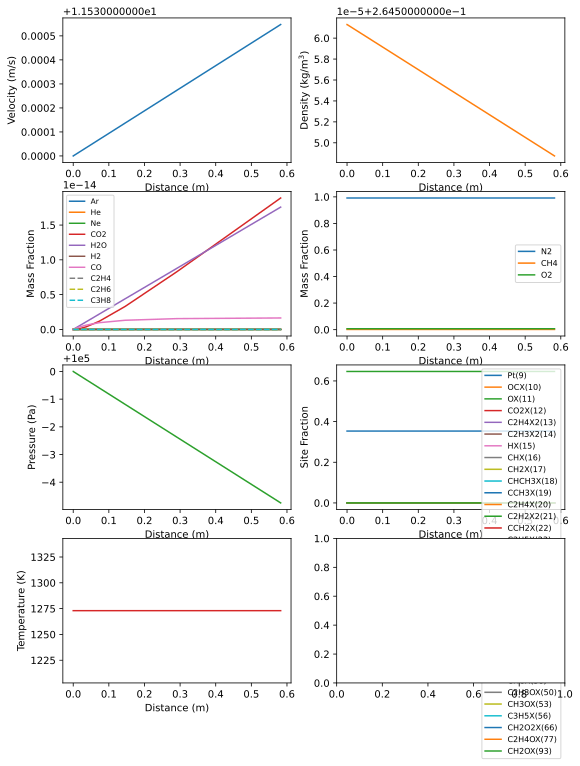

In [9]:
f, ax = plt.subplots(4, 2, figsize=(9, 12))

# plot gas velocity along the flow direction
ax[0, 0].plot(time, solution[:, 0], color="C0")
ax[0, 0].set_xlabel("Distance (m)")
ax[0, 0].set_ylabel("Velocity (m/s)")

# plot gas density along the flow direction
ax[0, 1].plot(time, solution[:, 1], color="C1")
ax[0, 1].set_xlabel("Distance (m)")
ax[0, 1].set_ylabel(r"Density ($\mathregular{kg/m^3}$)")
ax[0, 1].ticklabel_format(
    axis="y", style="sci", scilimits=(-2, 2)
)  # scientific notation

# plot major and minor gas species separately
minor_idx = []
major_idx = []
for i, name in enumerate(gas.species_names):
    mean = np.mean(solution[:, 2 + i])
    if mean <= 0.001:
        minor_idx.append(i)
    else:
        major_idx.append(i)

# plot minor gas species along the flow direction
for i in minor_idx:
    style = "-" if i < 10 else "--"
    ax[1, 0].plot(time, solution[:, 2 + i], label=gas.species_names[i], linestyle=style)
ax[1, 0].legend(fontsize=7.5, loc="best")
ax[1, 0].set_xlabel("Distance (m)")
ax[1, 0].set_ylabel("Mass Fraction")
ax[1, 0].ticklabel_format(
    axis="y", style="sci", scilimits=(-2, 2)
)  # scientific notation

# plot major gas species along the flow direction
for j in major_idx:
    ax[1, 1].plot(time, solution[:, 2 + j], label=gas.species_names[j])
ax[1, 1].legend(fontsize=8, loc="best")
ax[1, 1].set_xlabel("Distance (m)")
ax[1, 1].set_ylabel("Mass Fraction")

# plot the pressure of the gas along the flow direction
ax[2, 0].plot(time, solution[:, 2 + N], color="C2")
ax[2, 0].set_xlabel("Distance (m)")
ax[2, 0].set_ylabel("Pressure (Pa)")

# plot the site fraction of the surface species along the flow direction
for i, name in enumerate(gas_Si_N_interface.species_names):
    ax[2, 1].plot(time, solution[:, 3 + N + i], label=name)
ax[2, 1].legend(fontsize=8)
ax[2, 1].set_xlabel("Distance (m)")
ax[2, 1].set_ylabel("Site Fraction")

# plot the temperature profile along the flow direction
ax[3, 0].plot(time, solution[:, -1], color="C3")
ax[3, 0].set_xlabel("Distance (m)")
ax[3, 0].set_ylabel("Temperature (K)")
f.tight_layout(pad=0.5)